# charger le dataset

In [2]:
import pandas as pd

data1 = pd.read_csv('../dataset_version_4/knowledge_dataset_low_15p.csv')
data2 = pd.read_csv('../dataset_version_4/knowledge_dataset_mid_15p.csv')
data3 = pd.read_csv('../dataset_version_4/knowledge_dataset_high_15p.csv')

data4 = pd.read_csv('../dataset_version_4/knowledge_dataset_low_60p.csv') 
data5 = pd.read_csv('../dataset_version_4/knowledge_dataset_mid_60p.csv') 
data6 = pd.read_csv('../dataset_version_4/knowledge_dataset_high_60p.csv') 

data7 = pd.read_csv('../dataset_version_4/knowledge_dataset_low_1800p.csv')
data8 = pd.read_csv('../dataset_version_4/knowledge_dataset_mid_1800p.csv')
data9 = pd.read_csv('../dataset_version_4/knowledge_dataset_high_1800p.csv')


datas = [data1, data2, data3, data4, data5, data6, data7, data8, data9]

#data4[(data4['Reward_punishment'] > 0.6) & (data4['Label'] < 0.4)]

# Voir les information de base
### 1 - size
### 2 - distribution
### 3 - la moyenne du label

In [3]:
comp = 1
for data in datas :
    if comp == 1: 
        titre = '15 periodes low \n'
    elif comp == 2: 
        titre = '15 periodes mid \n'
    elif comp == 3: 
        titre = '15 periodes high \n'
    elif comp == 4: 
        titre = '60 periodes low \n'
    elif comp == 5: 
        titre = '60 periodes mid \n'
    elif comp == 6: 
        titre = '60 periodes high \n'
    elif comp == 7: 
        titre = '1800 periodes low \n'
    elif comp == 8: 
        titre = '1800 periodes mid \n'
    elif comp == 9: 
        titre = '1800 periodes high \n'

        
    print(f"--------------------{titre} ")

    print(f"1 - Dataset size : {data.shape}\n\n")

    print(f"2 - La distribution du label :\n{data['Label'].value_counts(normalize= True)}\n\n")

    print(f"3 - La moyenne du label est : {data['Label'].mean()}")
    comp = comp + 1

--------------------15 periodes low 
 
1 - Dataset size : (600, 6)


2 - La distribution du label :
Label
1.0    0.951667
0.0    0.021667
0.4    0.011667
0.6    0.010000
0.2    0.005000
Name: proportion, dtype: float64


3 - La moyenne du label est : 0.9633333333333334
--------------------15 periodes mid 
 
1 - Dataset size : (600, 6)


2 - La distribution du label :
Label
1.0    0.851667
0.0    0.076667
0.6    0.031667
0.2    0.021667
0.4    0.018333
Name: proportion, dtype: float64


3 - La moyenne du label est : 0.8823333333333333
--------------------15 periodes high 
 
1 - Dataset size : (600, 6)


2 - La distribution du label :
Label
1.0    0.780000
0.0    0.101667
0.4    0.040000
0.6    0.040000
0.2    0.038333
Name: proportion, dtype: float64


3 - La moyenne du label est : 0.8276666666666667
--------------------60 periodes low 
 
1 - Dataset size : (2400, 6)


2 - La distribution du label :
Label
1.0    0.958750
0.0    0.020417
0.6    0.012083
0.2    0.005417
0.4    0.003333
Na

# Voir les depondances entre le Label et les features

In [4]:
import matplotlib.pyplot as plt

def plot(df, comp):
    if comp == 1: 
        titre = '15 periodes low \n'
    elif comp == 2: 
        titre = '15 periodes mid \n'
    elif comp == 3: 
        titre = '15 periodes high \n'
    elif comp == 4: 
        titre = '60 periodes low \n'
    elif comp == 5: 
        titre = '60 periodes mid \n'
    elif comp == 6: 
        titre = '60 periodes high \n'
    elif comp == 7: 
        titre = '1800 periodes low \n'
    elif comp == 8: 
        titre = '1800 periodes mid \n'
    elif comp == 9: 
        titre = '1800 periodes high \n'
        
    X = df[['network_behaviour', 'data_collection_behaviour', 'Reward_punishment']]
    y = df['Label']
    
    plt.figure(figsize=(11, 4))  # Create a figure
    
    plt.subplot(1, 3, 1)
    plt.scatter(X['data_collection_behaviour'], y)
    plt.xlabel('network_behaviour')
    plt.ylabel('Comportement')

    plt.subplot(1, 3, 2)
    plt.scatter(X['data_collection_behaviour'], y)
    plt.xlabel('data_collection_behaviour')
    plt.ylabel('Comportement')

    plt.subplot(1, 3, 3)
    plt.scatter(X['Reward_punishment'], y)
    plt.xlabel('Reward_punishment')
    plt.ylabel('Comportement')
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])  
    
    plt.figtext(0.55, - 0.05, titre, ha='center', fontsize=14, color='green')  
    
    plt.show()  # Display the plot

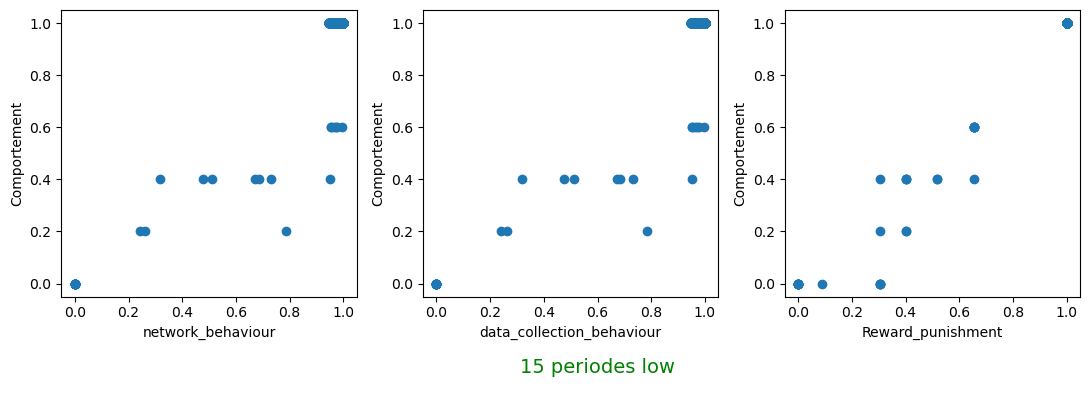

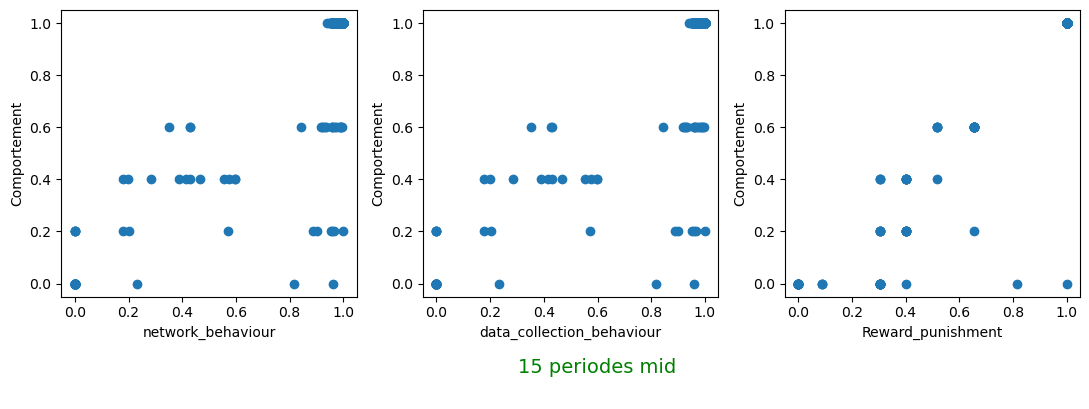

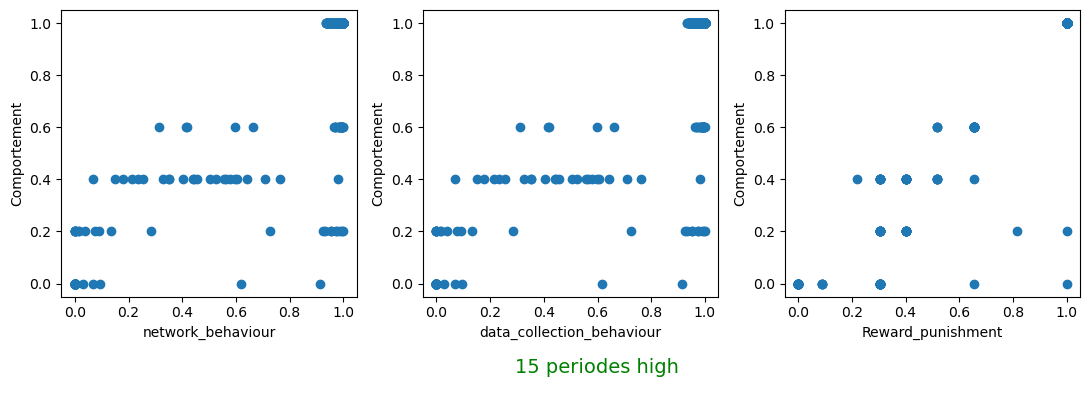

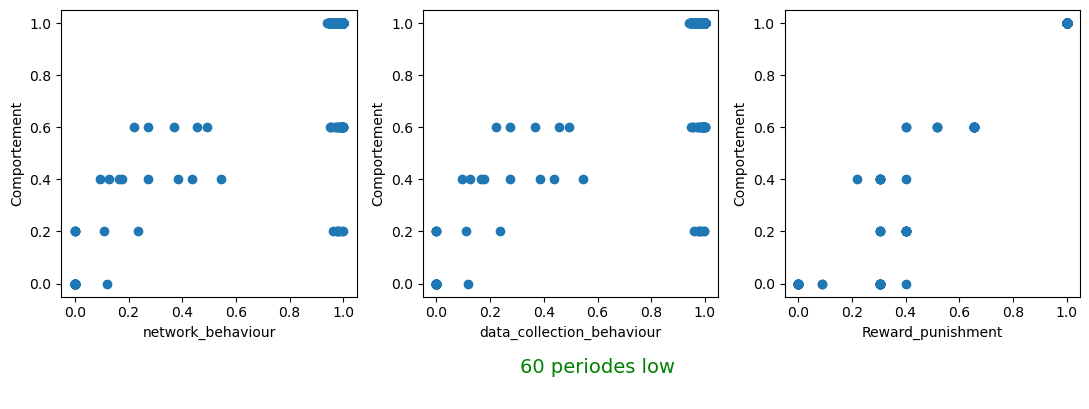

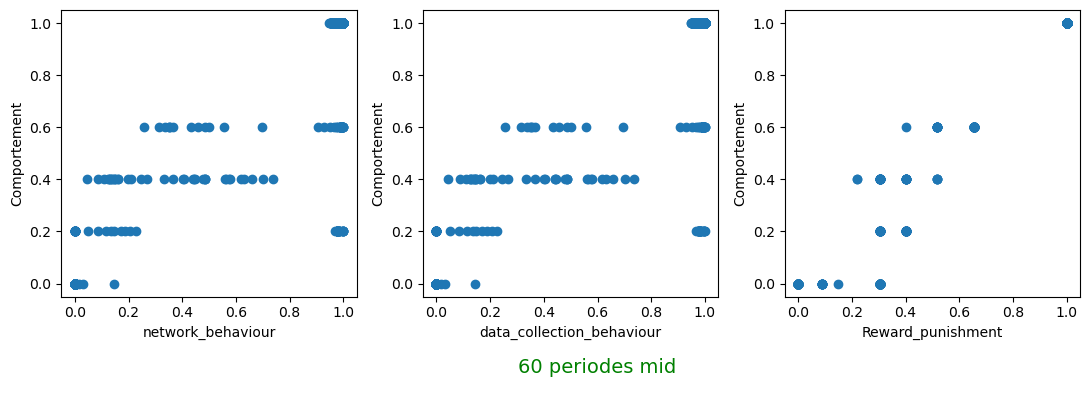

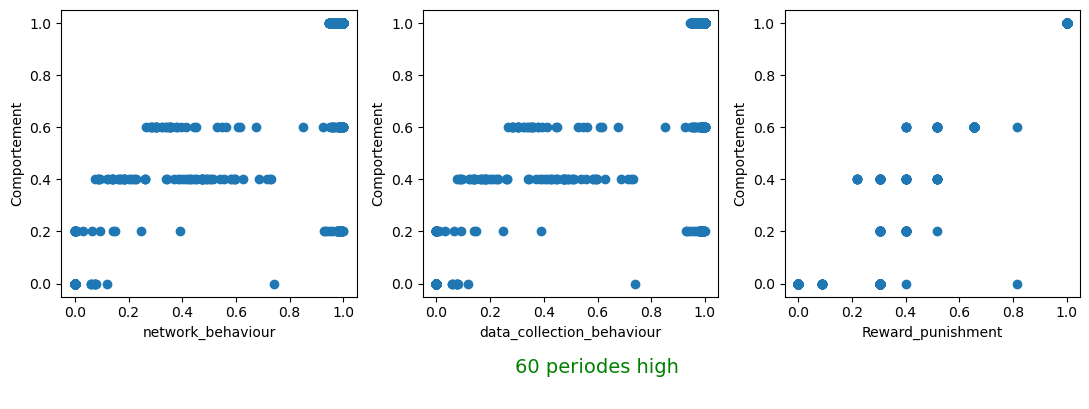

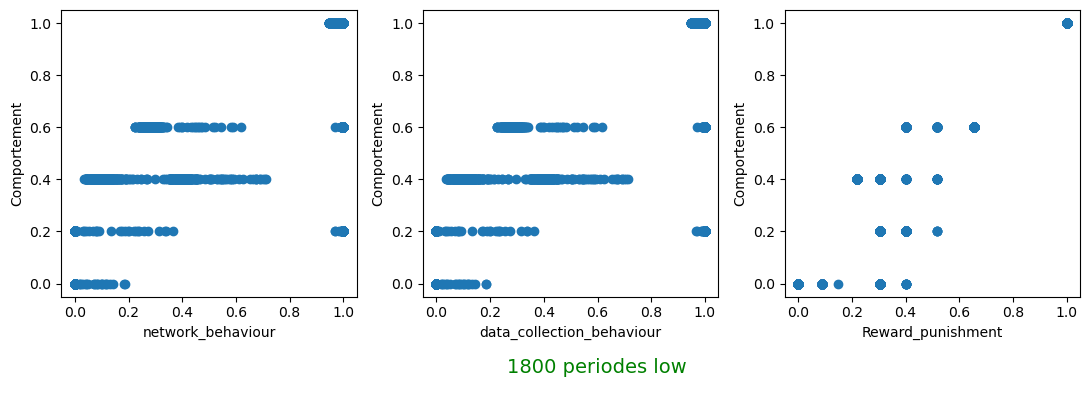

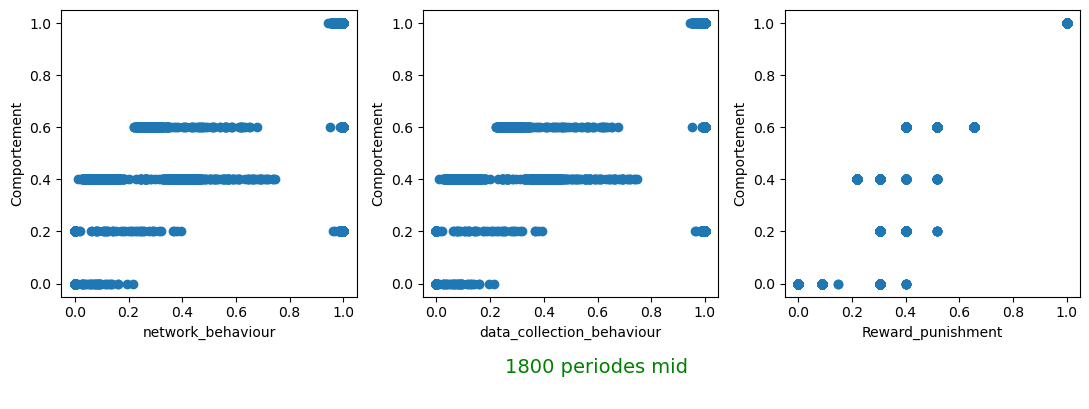

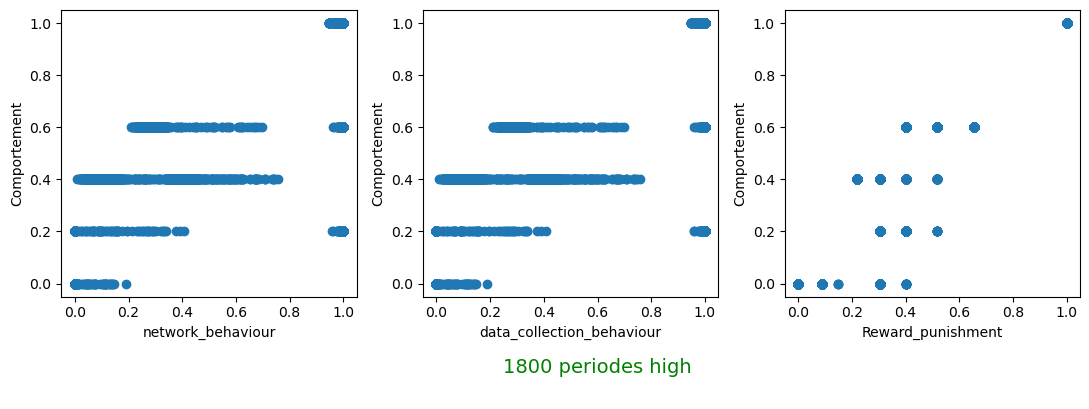

In [5]:
import matplotlib.pyplot as plt
comp = 1
for data in datas :
    plot(data, comp)
    comp = comp + 1

# Model training

## - Model

###  1 - Définition des fonctions objetif et contraintes
###  2 - features, Label splitting, classifier le label pour preparer la crossvalidation
###  3 - trainset, testset splitting & crossvalidation
###  4 - train the model and view the MSE and MAPE scores for the testset

In [6]:
import time
from sklearn.model_selection import train_test_split, StratifiedKFold
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE

def objective(coeffs, X, y):
    predictions = np.dot(X, coeffs)
    score = 0
    for pred, actual in zip(predictions, y):
        if actual <= 0.8:
            weight = 3
        else:
            weight = 1
        score += weight * (actual - pred)**2  
    return score / len(predictions)

def constraint_eq(coeffs):
    return np.sum(coeffs) - 1

def MAPE(actuals, predictions):
    mape = 0
    for pred, actual in zip(predictions, actuals):
        mape += abs(pred - actual) * 100
    return mape / len(predictions)

def label_bin(df):
    classes = np.zeros(len(df), dtype=int)    
    for i, value in enumerate(df['Label']):
        if value < 0.2:
            classes[i] = 0
        elif value < 0.4:
            classes[i] = 1
        elif value < 0.6:
            classes[i] = 2
        elif value < 0.8:
            classes[i] = 3
        elif value <= 1.0:
            classes[i] = 4            
    return classes

In [7]:
def train_test_model(df, comp): 
    if comp == 1: 
        titre = '15p_low \n'
    elif comp == 2: 
        titre = '15p_mid \n'
    elif comp == 3: 
        titre = '15p_high \n'
    elif comp == 4: 
        titre = '60p_low \n'
    elif comp == 5: 
        titre = '60p_mid \n'
    elif comp == 6: 
        titre = '60p_high \n'
    elif comp == 7: 
        titre = '1800p_low \n'
    elif comp == 8: 
        titre = '1800p_mid \n'
    elif comp == 9: 
        titre = '1800p_high \n'
     
    print(f"------------------------------------ {titre}")
    
    # Feature, target splitting
    X = df[['network_behaviour', 'data_collection_behaviour', 'Reward_punishment']]
    y = df['Label']
    
    y_binned = label_bin(df)
    
    # stratified Train - Test splitting 
    X_train_full, X_test, y_train_full, y_test, y_binned_train, y_binned_test = train_test_split(
                                                    X, y, y_binned, test_size=0.2, random_state=0, stratify=y_binned)
    
    
    initial_coeffs = np.array([1/3, 1/3, 1/3])

    
    cons = [
        {'type': 'eq', 'fun': constraint_eq},
        {'type': 'ineq', 'fun': lambda x: x[0]},  # a >= 0
        {'type': 'ineq', 'fun': lambda x: x[1]},  # b >= 0
        {'type': 'ineq', 'fun': lambda x: x[2]},  # c >= 0
    ]

    best_coeffs = np.array([1/3, 1/3, 1/3])
    mse_scores = [] 
    mape_scores = []
    
    # stratified Cross-validation on the train set
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    

    start_time = time.time()  # Start time
    for train_index, val_index in kf.split(X_train_full, y_binned_train):
        X_train = X_train_full.iloc[train_index] 
        y_train = y_train_full.iloc[train_index]
        X_val =  X_train_full.iloc[val_index]
        y_val = y_train_full.iloc[val_index]

        result = minimize(objective, initial_coeffs, args=(X_train, y_train), constraints=cons)
        coeffs = result.x

        predictions = np.dot(X_val, coeffs)

        mse = mean_squared_error(y_val, predictions)
        mape = MAPE(y_val, predictions)

        mse_scores.append(mse)
        mape_scores.append(mape)

        if mse < mean_squared_error(y_val, np.dot(X_val, best_coeffs)):
            best_coeffs = coeffs

    # Evaluate on the test set using the best coefficients found during cross-validation
    final_predictions = np.dot(X_test, best_coeffs)
    final_mse = mean_squared_error(y_test, final_predictions)
    final_mape = MAPE(y_test, final_predictions)

    mean_mse = np.mean(mse_scores)
    std_mse = np.std(mse_scores)
    mean_mape = np.mean(mape_scores)
    std_mape = np.std(mape_scores)

    end_time = time.time()  # End time
    execution_time = end_time - start_time  # Calculate execution time
    
    print(f"Best Parameters: {best_coeffs}\n\n")
    print(f"Execution time for the model: {execution_time} seconds \n\n")
    '''
    print(f"MSE Scores (Validation): {mse_scores}")
    print(f"Moy MSE (Validation): {mean_mse}, Std MSE: {std_mse}\n\n")
    print(f"MAPE Scores (Validation): {mape_scores}")
    print(f"Moy MAPE (Validation): {mean_mape}, Std MAPE: {std_mape}\n")
    print(f"MSE (Test): {final_mse}")
    print(f"MAPE (Test): {final_mape}")
    '''

    return best_coeffs, titre, final_mse, final_mape


In [8]:
comp = 1
datasets = []
mse_scores = []
mape_scores = []
coeffs = []
comp = 1
for data in datas :
    coeff, dataset, mse, mape = train_test_model(data, comp)
    coeffs.append(coeff)
    datasets.append(dataset)
    mse_scores.append(mse)
    mape_scores.append(mape)
    comp = comp + 1

------------------------------------ 15p_low 

Best Parameters: [1.77029005e-17 1.37292328e-01 8.62707672e-01]


Execution time for the model: 0.05095958709716797 seconds 


------------------------------------ 15p_mid 

Best Parameters: [6.45969464e-17 8.82492206e-02 9.11750779e-01]


Execution time for the model: 0.06931138038635254 seconds 


------------------------------------ 15p_high 

Best Parameters: [1.34226038e-17 1.72836293e-01 8.27163707e-01]


Execution time for the model: 0.0542149543762207 seconds 


------------------------------------ 60p_low 



D:\anaconda\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters: [-8.39190576e-17  8.47885342e-02  9.15211466e-01]


Execution time for the model: 0.14159131050109863 seconds 


------------------------------------ 60p_mid 

Best Parameters: [-3.63431804e-17  1.01008759e-01  8.98991241e-01]


Execution time for the model: 0.1235508918762207 seconds 


------------------------------------ 60p_high 

Best Parameters: [-3.26246386e-17  1.42193542e-01  8.57806458e-01]


Execution time for the model: 0.11259770393371582 seconds 


------------------------------------ 1800p_low 

Best Parameters: [-3.22035187e-18  1.00430640e-01  8.99569360e-01]


Execution time for the model: 2.970160722732544 seconds 


------------------------------------ 1800p_mid 

Best Parameters: [4.68760690e-17 1.19589134e-01 8.80410866e-01]


Execution time for the model: 2.9575302600860596 seconds 


------------------------------------ 1800p_high 

Best Parameters: [4.05624940e-17 1.11642942e-01 8.88357058e-01]


Execution time for the model: 2.673947811126709 

# Tests on the final Trust calculation

# Test et scores

### 1 - MSE et MAPE en fonction des simulations

#### - ici nous predicterons le scores MSE qui est la moyenne des distances caree entre la prediction et la realite pour les differets cas de simulations et attaques
#### - nous predicterons aussi le score MAPE qui est la moyenne du pourcentage d'erreur du modele pour les differets cas de simulations et attaques


### 2 - MSE et MAPE en fonction des attaques par periode

#### - nous calculerons les scores MSE ET MAPE pour les differantes frequance d'attaques par periode

### 3 - erreurs de prediction en fonction du score

#### - nous calculerons les scores MSE ET MAPE pour les differaantes tranche du label (pour percecvoir les erreurs et voir si elle seront critiques)
#### - le label sera decoupée comme suit :  [0-0.1[ ----  [0.1,0,2[  ----  [0.2,0.3[ ---- [0.3,0.4[ ---- [0.4,0.5[ ---- [0.5,0.6[ ---- [0.6,0.8[ ---- [0.8,1]

### 4 - test contre les attaques

##  - Test 1 :  MSE et MAPE en fonction des simulations

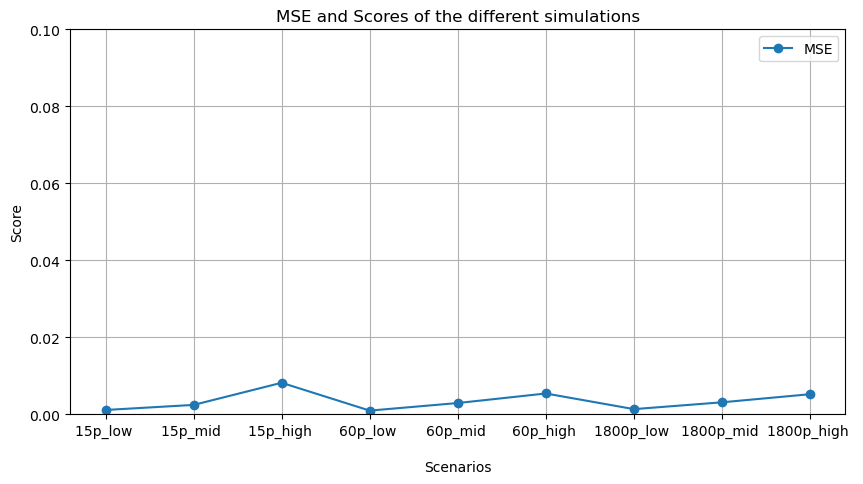

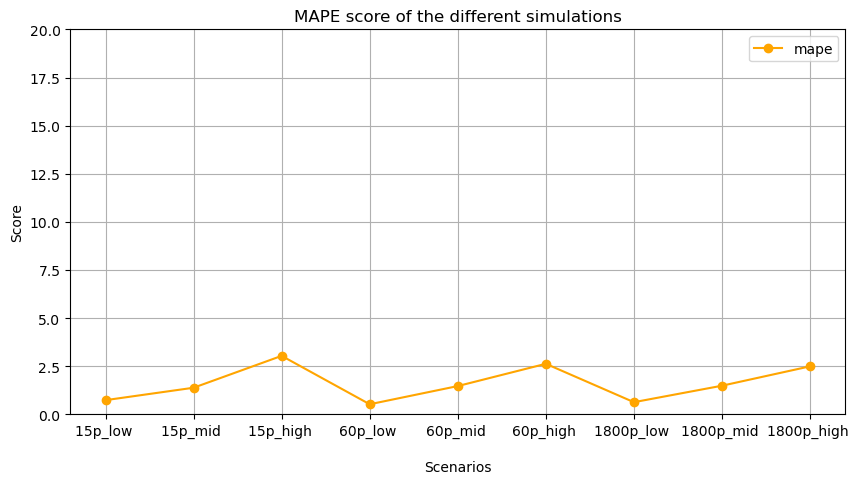

In [148]:
# Plot the scores
plt.figure(figsize=(10, 5))
plt.plot(datasets, mse_scores, label='MSE', marker='o')
plt.xlabel('Scenarios')
plt.ylabel('Score')
plt.title('MSE and Scores of the different simulations')
plt.ylim(0, 0.1)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(datasets, mape_scores, label='mape', marker='o', c="orange")
plt.xlabel('Scenarios')
plt.ylabel('Score')
plt.title('MAPE score of the different simulations')
plt.ylim(0, 20)
plt.legend()
plt.grid(True)
plt.show()

## Test 2 - MSE et MAPE en fonction des attaques par periode

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

def attaques_per_periode(df, comp) :

    if comp == 1: 
        titre = '15p_low \n'
    elif comp == 2: 
        titre = '15p_mid \n'
    elif comp == 3: 
        titre = '15p_high \n'
    elif comp == 4: 
        titre = '60p_low \n'
    elif comp == 5: 
        titre = '60p_mid \n'
    elif comp == 6: 
        titre = '60p_high \n'
    elif comp == 7: 
        titre = '1800p_low \n'
    elif comp == 8: 
        titre = '1800p_mid \n'
    elif comp == 9: 
        titre = '1800p_high \n'

    # Initialize lists to store results
    periods = []
    mse_scores = []
    mape_scores = []
    malicious_counts = []

    # Process each period
    unique_periods = df['periode'].unique()

    for period in unique_periods:
    
        #feature / Label for the periode selected
        df_period = df[df['periode'] == period]
        X = df_period[['network_behaviour', 'data_collection_behaviour', 'Reward_punishment']]
        y = df_period['Label']
    
        # Count the number of attacks (Label < 1)
        malicious_count = (y < 1).sum()
        malicious_counts.append(malicious_count)
        
        # Prediction and scores
        predictions = np.dot(X, coeffs[i-1])
        mse = mean_squared_error(y, predictions)
        mape = MAPE(y, predictions)
        
        # Store the results
        periods.append(period)
        mse_scores.append(mse)
        mape_scores.append(mape)
 

    # Plot the MSE results
    plt.figure(figsize=(14, 6))
    plt.suptitle(f"MSE & MAPE Scores vs nombre d'attaques par periode for {titre}", y=1.02)
    
    plt.subplot(1, 2, 1)
    plt.scatter(malicious_counts, mse_scores, label='MSE', marker='o', color='red')
    plt.xlabel("nombre d'attaques (Malicious Nodes) par periode")
    plt.ylabel('MSE Score')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 0.1)

    plt.subplot(1, 2, 2)
    plt.scatter(malicious_counts, mape_scores, label='MAPE Score', marker='o', color='blue')
    plt.xlabel("nombre d'attaques (Malicious Nodes) par periode")
    plt.ylabel('MAPE Score')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 20)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show() 


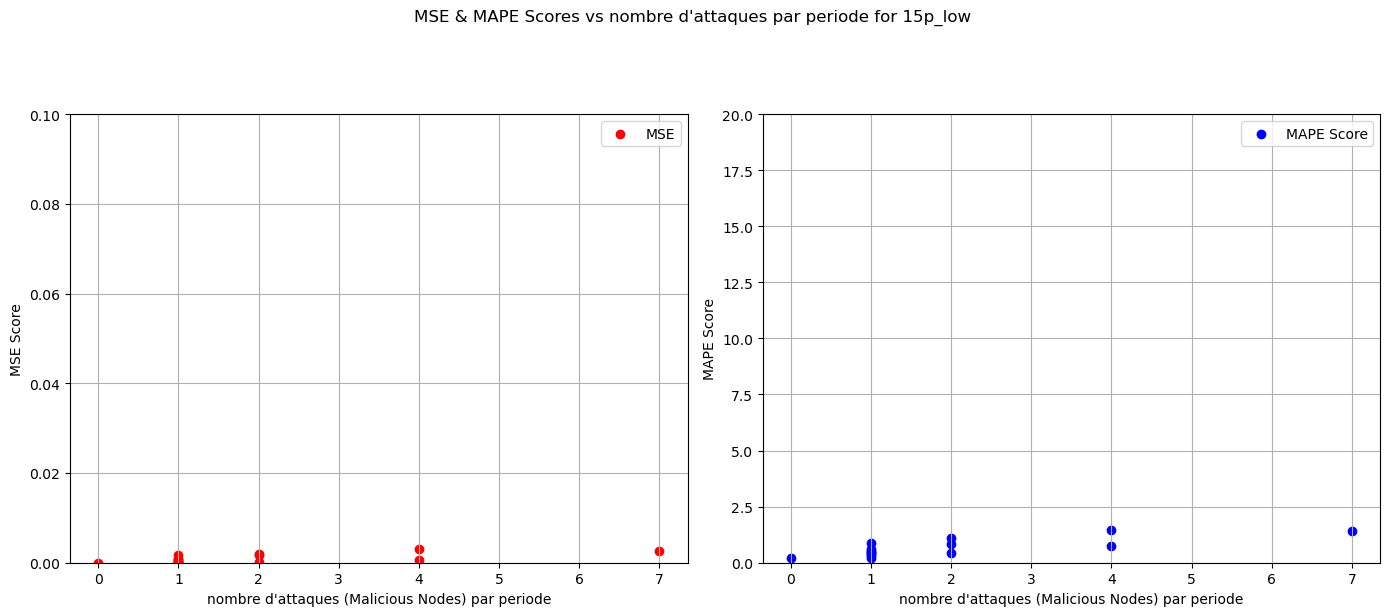

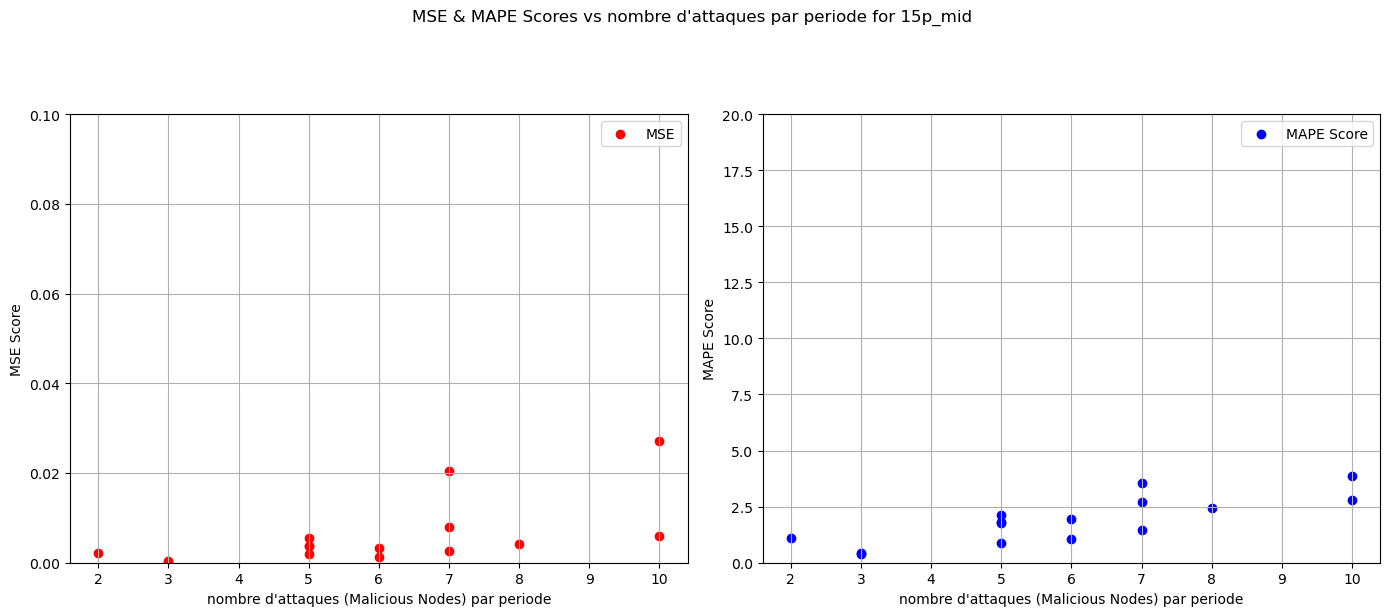

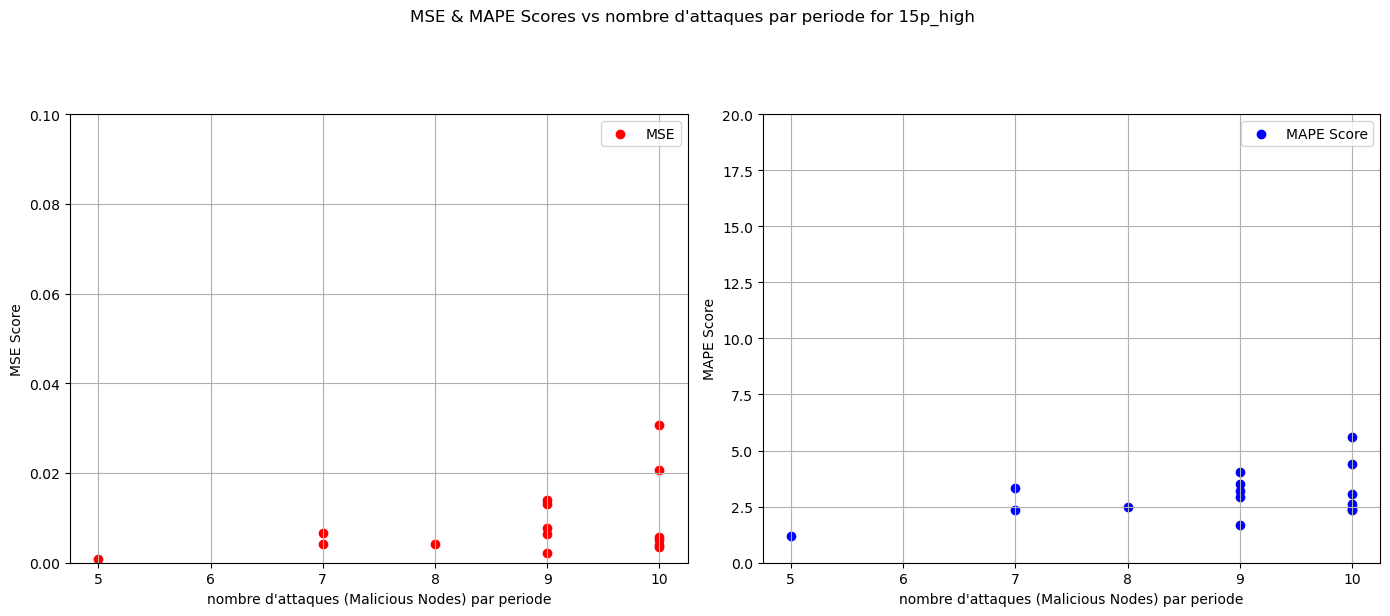

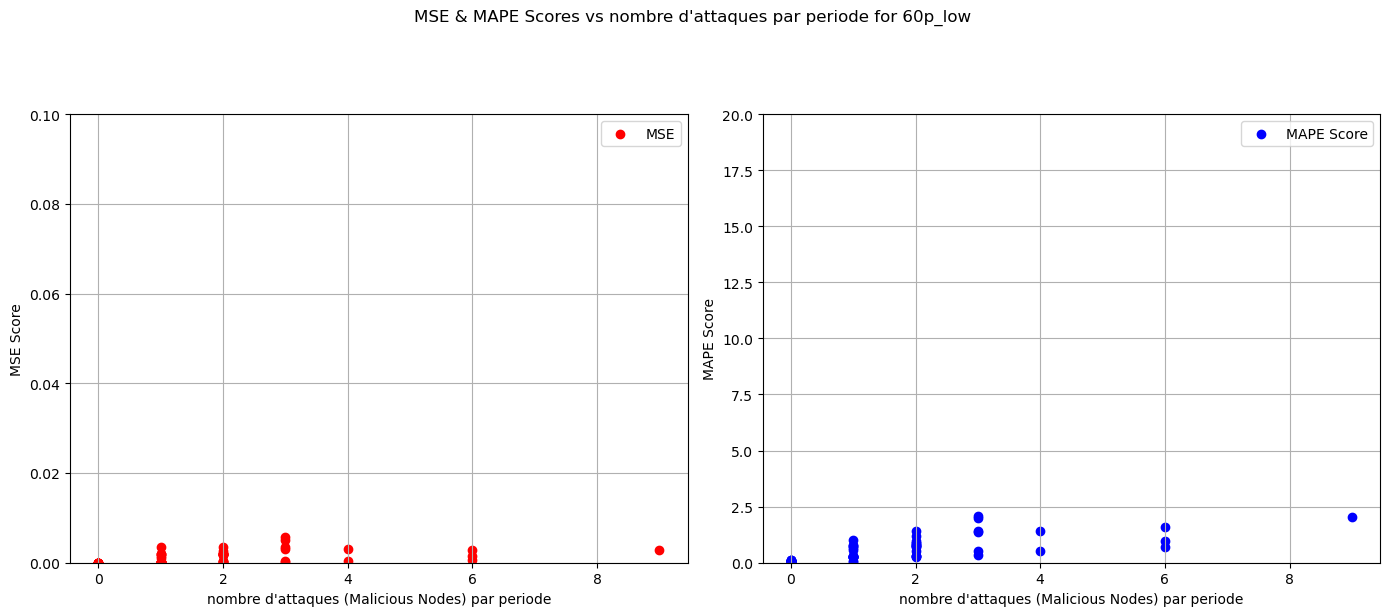

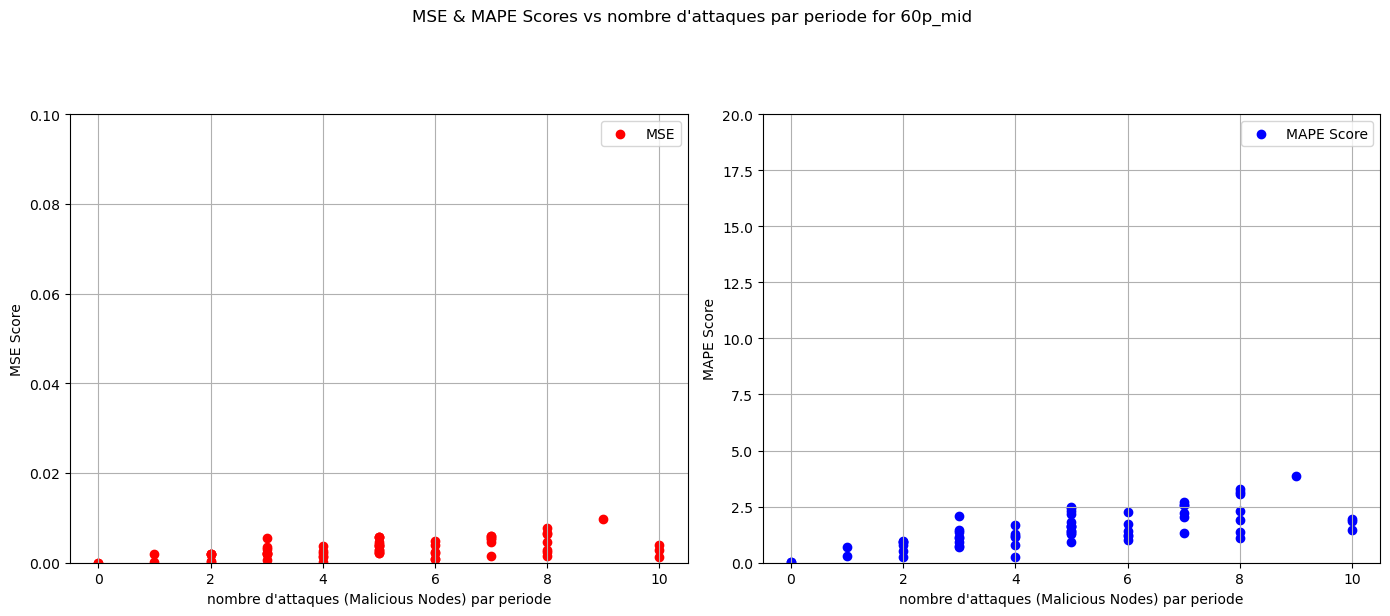

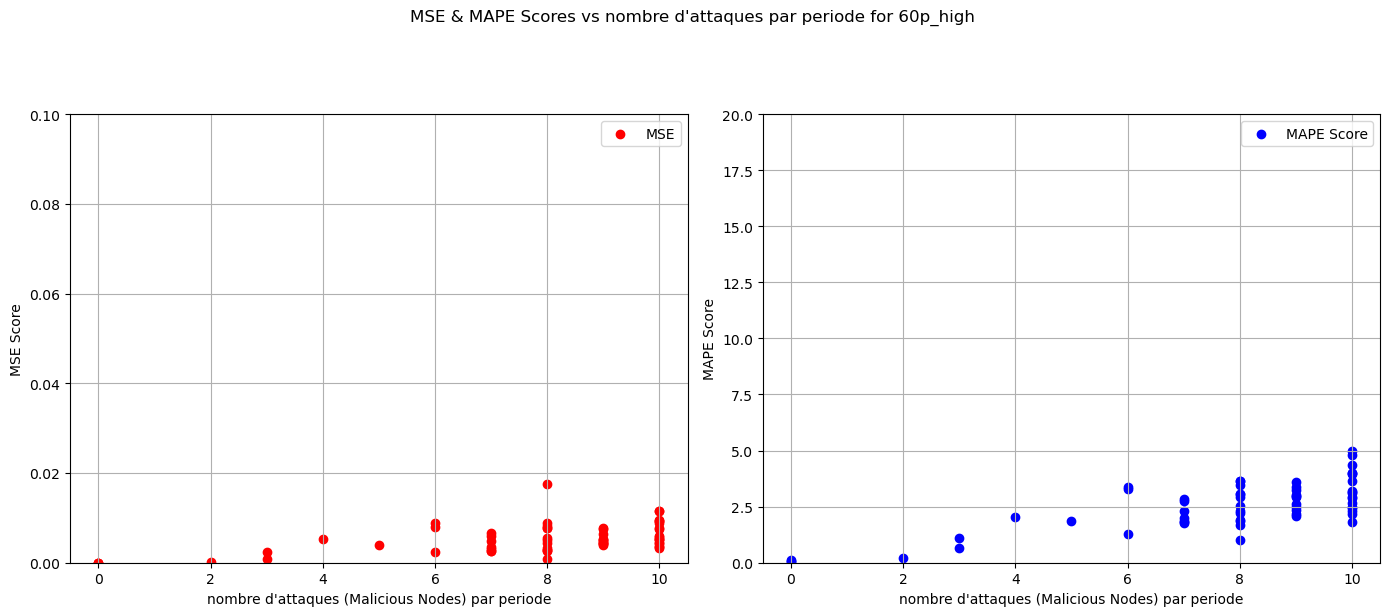

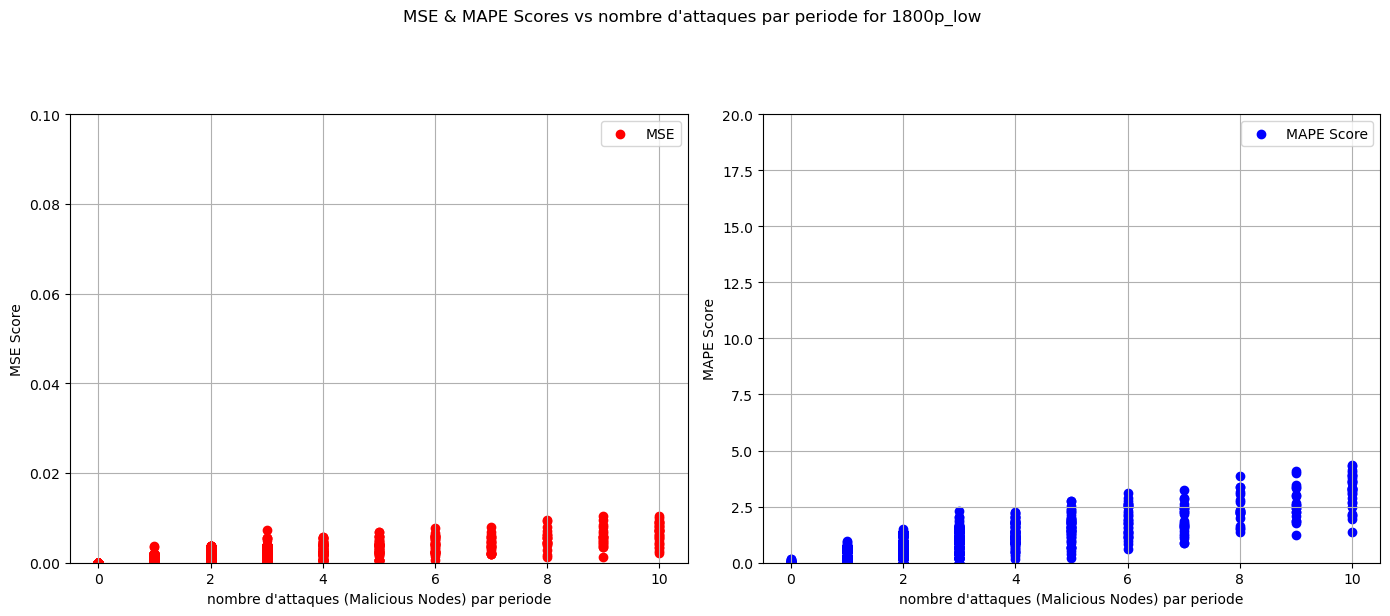

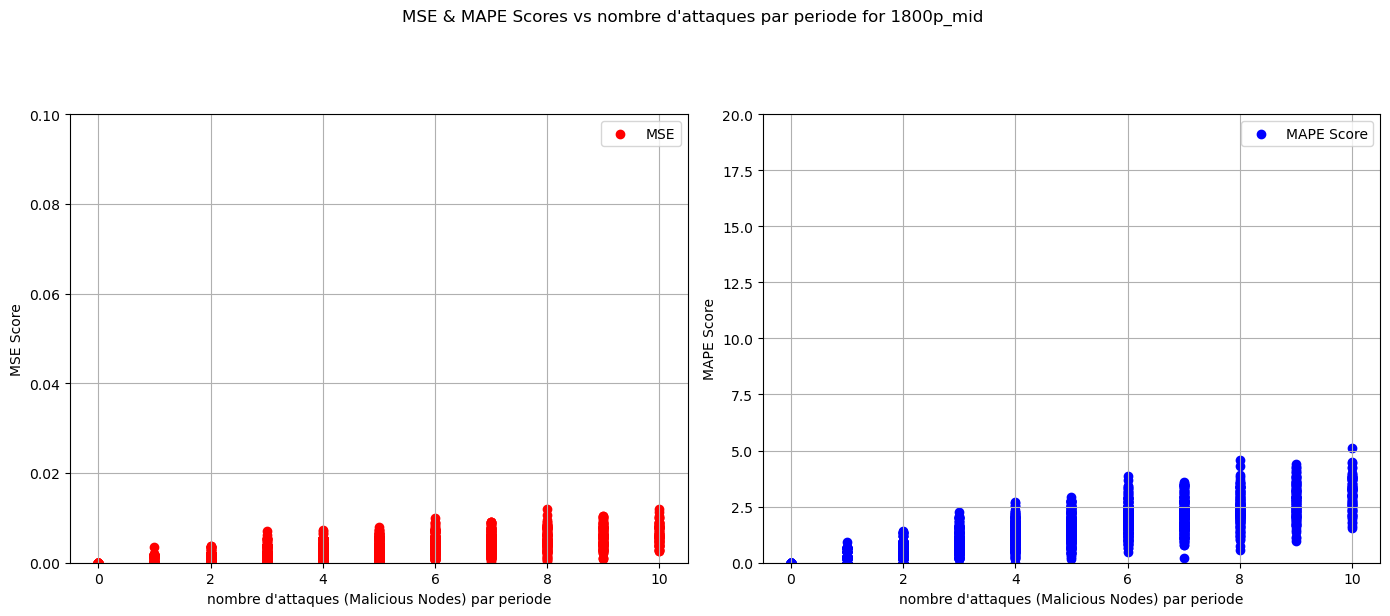

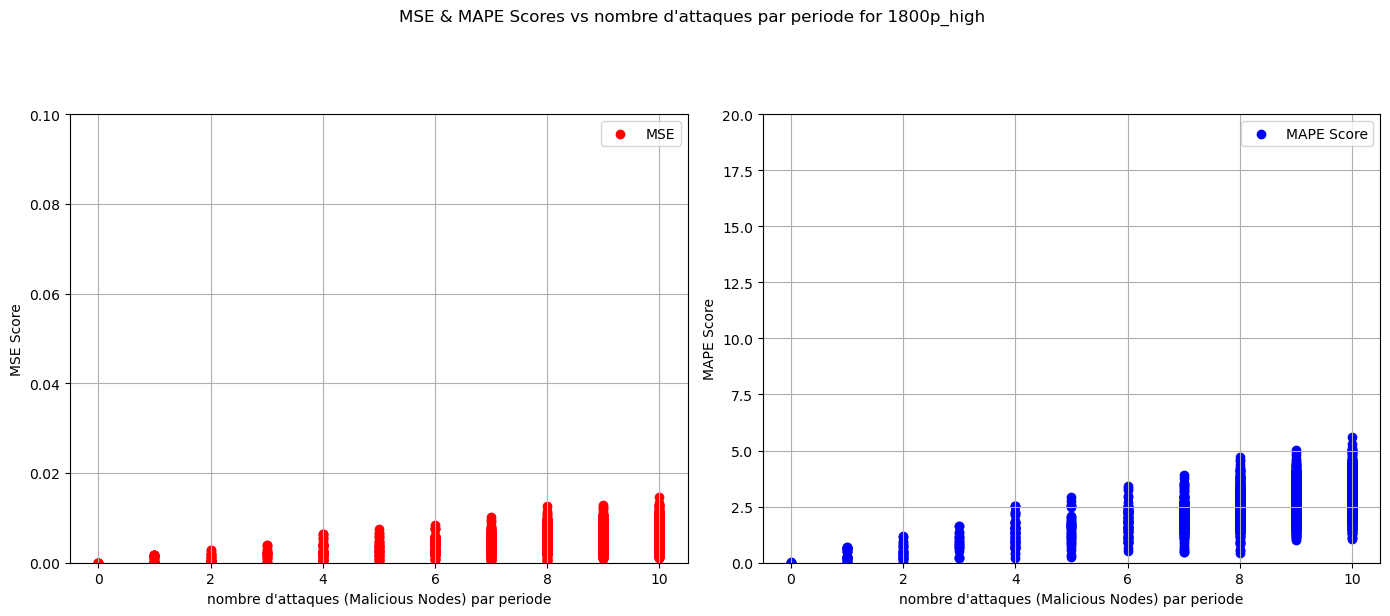

In [150]:
i = 1
for data in datas :
    attaques_per_periode(data, i)
    i = i + 1

## Test 3 - erreurs de prediction en fonction du Label

# Verifications

In [70]:
df1 = data4[data4['Label'] < 0.2]
df2 = data4[(data4['Label'] >= 0.2) & (data4['Label'] < 0.4)]
df3 = data4[(data4['Label'] >= 0.4) & (data4['Label'] < 0.6)]
df4 = data4[(data4['Label'] >= 0.6) & (data4['Label'] < 0.8)]
df5 = data4[(data4['Label'] >= 0.8) & (data4['Label'] <= 1.0)]

dfs =  [df1, df2, df3, df4, df5 ]
for df in dfs :
    X = df[['network_behaviour', 'data_collection_behaviour', 'Reward_punishment']]
    y = df['Label']
    df['Predictions'] = np.nan
    predictions = np.dot(X, coeffs[1])
    df.loc[df.index, 'Predictions'] = predictions

C:\Users\GAMMING\AppData\Local\Temp\ipykernel_13856\1930337902.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Predictions'] = np.nan
C:\Users\GAMMING\AppData\Local\Temp\ipykernel_13856\1930337902.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Predictions'] = np.nan
C:\Users\GAMMING\AppData\Local\Temp\ipykernel_13856\1930337902.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

# Test 3

In [37]:
#conditions pour chaque attaques : 

#not send                11560           11682
#data9[(data9['Label'] == 0 ) & (data9['network_behaviour'] == 0)].iloc[600:620,:]       

# send 6                 71891           71882
#data9[(data9['Label'] == 0.6 ) & (data9['network_behaviour'] == 0.6) & (data9['data_collection_behaviour'] > 0.9)]

# send 2                 223            71602    
#data9[(data9['Label'] == 0.2 ) & (data9['network_behaviour'] == 0.2) & (data9['data_collection_behaviour'] > 0.95)]

# all fake               71928          71962
data9[(data9['Label'] == 0 ) & (data9['network_behaviour'] == 1) & (data9['data_collection_behaviour'] < 0.1) ]

# send_4_fake            26174          41642  
#data9[(data9['Label'] == 0.6 ) & (data9['network_behaviour'] == 1) & (data9['data_collection_behaviour'] > 0.5) ]
 
# send_8_fake            71572                     
#data9[(data9['Label'] == 0.2 ) & (data9['network_behaviour'] == 1) & (data9['data_collection_behaviour'] < 0.5) ]

# Send_4_Fake_Out_8      31562          22842
#data9[(data9['Label'] == 0.4 ) & (data9['network_behaviour'] == 0.8) & (data9['data_collection_behaviour'] > 0.4) ]

# Send_4_Fake_Out_4      71088          71640
#data9[(data9['Label'] == 0 ) & (data9['network_behaviour'] == 0.4) & (data9['data_collection_behaviour'] < 0.4) ]

# Send_2_Fake_Out_6      71338          71360
#data9[(data9['Label'] == 0.4 ) & (data9['network_behaviour'] == 0.6) & (data9['data_collection_behaviour'] < 0.8) ]

# no attacks             71994          50082     
#data9[(data9['Label'] == 1 ) & (data9['network_behaviour'] > 0.9) & (data9['data_collection_behaviour'] > 0.9) ]

,Label,NodeID,network_behaviour,data_collection_behaviour,Reward_punishment,periode
9,0.0,s3_f2,1.0,0.0,0.303265,1
50,0.0,s3_h1,1.0,0.0,0.303265,2
57,0.0,s1_h3,1.0,0.0,0.303265,2
78,0.0,s3_f5,1.0,0.0,0.303265,2
102,0.0,s3_f3,1.0,0.0,0.303265,3
...,...,...,...,...,...,...
71928,0.0,s3_f1,1.0,0.0,0.303265,1799
71962,0.0,s1_h1,1.0,0.0,0.303265,1800
71963,0.0,s1_h2,1.0,0.0,0.303265,1800
71978,0.0,s1_h4,1.0,0.0,0.303265,1800


In [18]:
raw = data5.iloc[71951,:]       # not send
print("---------------not send")
y = raw['Label']
x = raw[['network_behaviour', 'data_collection_behaviour', 'Reward_punishment']]
info = raw[['NodeID', 'periode']]
x.drop(columns=['NodeID'], inplace = True)
predictions = np.dot(x, coeffs[4])
print (f"{info[0]} dans la periode {info[1]} \n")
print(f"NTB : {x[0]}, DCB : {x[1]}, RWP : {x[2]} \n\n\n\n")
#print (f"reel : {y} predite : {predictions} \n\n")


raw =data5.iloc[320,:]          # send 6
print("---------------send 6")
y = raw['Label']
x = raw[['network_behaviour', 'data_collection_behaviour', 'Reward_punishment']]
info = raw[['NodeID', 'periode']]
x.drop(columns=['NodeID'], inplace = True)
predictions = np.dot(x, coeffs[4])
print (f"{info[0]} dans la periode {info[1]} \n")
print(f"NTB : {x[0]}, DCB : {x[1]}, RWP : {x[2]} \n\n\n\n")
#print (f"reel : {y} predite : {predictions} \n\n")


raw =data5.iloc[21646,:]         # send 2
print("---------------send 2")
y = raw['Label']
x = raw[['network_behaviour', 'data_collection_behaviour', 'Reward_punishment']]
info = raw[['NodeID', 'periode']]
x.drop(columns=['NodeID'], inplace = True)
predictions = np.dot(x, coeffs[4])
print (f"{info[0]} dans la periode {info[1]} \n")
print(f"NTB : {x[0]}, DCB : {x[1]}, RWP : {x[2]} \n\n\n\n")
#print (f"reel : {y} predite : {predictions} \n\n")

raw =data5.iloc[71922,:]       # send all fake
print("---------------send all fake")
y = raw['Label']
x = raw[['network_behaviour', 'data_collection_behaviour', 'Reward_punishment']]
info = raw[['NodeID', 'periode']]
x.drop(columns=['NodeID'], inplace = True)
predictions = np.dot(x, coeffs[4])
print (f"{info[0]} dans la periode {info[1]} \n")
print(f"NTB : {x[0]}, DCB : {x[1]}, RWP : {x[2]} \n\n\n\n")
#print (f"reel : {y} predite : {predictions} \n\n")


raw =data5.iloc[38842,:]       # send 4 fake
print("---------------send 4 fake")
y = raw['Label']
x = raw[['network_behaviour', 'data_collection_behaviour', 'Reward_punishment']]
info = raw[['NodeID', 'periode']]
x.drop(columns=['NodeID'], inplace = True)
predictions = np.dot(x, coeffs[4])
print (f"{info[0]} dans la periode {info[1]} \n")
print(f"NTB : {x[0]}, DCB : {x[1]}, RWP : {x[2]} \n\n\n\n")
#print (f"reel : {y} predite : {predictions} \n\n")


raw =data5.iloc[71842,:]       # send 8 fake 
print("---------------send 8 fake")
y = raw['Label']
x = raw[['network_behaviour', 'data_collection_behaviour', 'Reward_punishment']]
info = raw[['NodeID', 'periode']]
x.drop(columns=['NodeID'], inplace = True)
predictions = np.dot(x, coeffs[4])
print (f"{info[0]} dans la periode {info[1]} \n")
print(f"NTB : {x[0]}, DCB : {x[1]}, RWP : {x[2]} \n\n\n\n")
#print (f"reel : {y} predite : {predictions} \n\n")


raw =data5.iloc[37882,:]         # send 4 fake out 8
print("---------------send 4 fake out 8")
y = raw['Label']
x = raw[['network_behaviour', 'data_collection_behaviour', 'Reward_punishment']]
info = raw[['NodeID', 'periode']]
x.drop(columns=['NodeID'], inplace = True)
predictions = np.dot(x, coeffs[4])
print (f"{info[0]} dans la periode {info[1]} \n")
print(f"NTB : {x[0]}, DCB : {x[1]}, RWP : {x[2]} \n\n\n\n")
#print (f"reel : {y} predite : {predictions} \n\n")


raw =data5.iloc[555,:]         # send 4 fake out 4
print("---------------send 4 fake out 4")
y = raw['Label']
x = raw[['network_behaviour', 'data_collection_behaviour', 'Reward_punishment']]
info = raw[['NodeID', 'periode']]
x.drop(columns=['NodeID'], inplace = True)
predictions = np.dot(x, coeffs[4])
print (f"{info[0]} dans la periode {info[1]} \n")
print(f"NTB : {x[0]}, DCB : {x[1]}, RWP : {x[2]} \n\n\n\n")
#print (f"reel : {y} predite : {predictions} \n\n")


raw =data5.iloc[602,:]         # send 2 fake out 6
print("---------------send 2 fake out 6")
y = raw['Label']
x = raw[['network_behaviour', 'data_collection_behaviour', 'Reward_punishment']]
info = raw[['NodeID', 'periode']]
x.drop(columns=['NodeID'], inplace = True)
predictions = np.dot(x, coeffs[4])
print (f"{info[0]} dans la periode {info[1]} \n")
print(f"NTB : {x[0]}, DCB : {x[1]}, RWP : {x[2]} \n\n\n\n")
#print (f"reel : {y} predite : {predictions} \n\n")

IndexError: single positional indexer is out-of-bounds

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def view(df, i):
    
    if i == 1: 
        titre = '15 periodes manuel \n'
    elif i == 2: 
        titre = '60 periodes manuel\n'
    elif i == 3: 
        titre = '15 periodes aléatoire \n'
    elif i == 4: 
        titre = '60 periodes aléatoire \n'
    elif i == 5: 
        titre = '1800 periodes aléatoire \n'

    # Initialize lists to store results
    mse_scores = []
    mape_scores = []
    label_ranges = ['0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1.0']
    
    # Segment the data based on 'Label'
    df_segments = [
        df[df['Label'] < 0.1],
        df[(df['Label'] >= 0.1) & (df['Label'] < 0.2)],
        df[(df['Label'] >= 0.2) & (df['Label'] < 0.3)],
        df[(df['Label'] >= 0.3) & (df['Label'] < 0.4)],
        df[(df['Label'] >= 0.4) & (df['Label'] < 0.5)],
        df[(df['Label'] >= 0.5) & (df['Label'] < 0.6)],
        df[(df['Label'] >= 0.6) & (df['Label'] < 0.7)],
        df[(df['Label'] >= 0.7) & (df['Label'] < 0.8)],
        df[(df['Label'] >= 0.8) & (df['Label'] < 0.9)],
        df[(df['Label'] >= 0.9) & (df['Label'] <= 1)]
    ]

    for segment in df_segments:
        if segment.empty:
            mse_scores.append(0)
            mape_scores.append(0)
        else:
            X = segment[['network_behaviour', 'data_collection_behaviour', 'Reward_punishment']]
            y = segment['Label']
            
            # Prediction and scores
            predictions = np.dot(X, coeffs[i-1])
            mse = mean_squared_error(y, predictions)
            mape = MAPE(y, predictions)
            
            # Store the results
            mse_scores.append(mse)
            mape_scores.append(mape)
 
    # Plot the MSE results
    plt.figure(figsize=(12, 6))
    plt.scatter(label_ranges, mse_scores, label='MSE', marker='o', color='red')
    plt.xlabel("Label Ranges")
    plt.ylabel('MSE Score')
    plt.title(f"MSE Score vs Label Ranges for {titre}")
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 0.5)
    plt.show()

    # Plot the MAPE results
    plt.figure(figsize=(12, 6))
    plt.scatter(label_ranges, mape_scores, label='MAPE', marker='o', color='blue')
    plt.xlabel("Label Ranges")
    plt.ylabel('MAPE Score')
    plt.title(f"MAPE Score vs Label Ranges for {titre}")
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 20)
    plt.show()


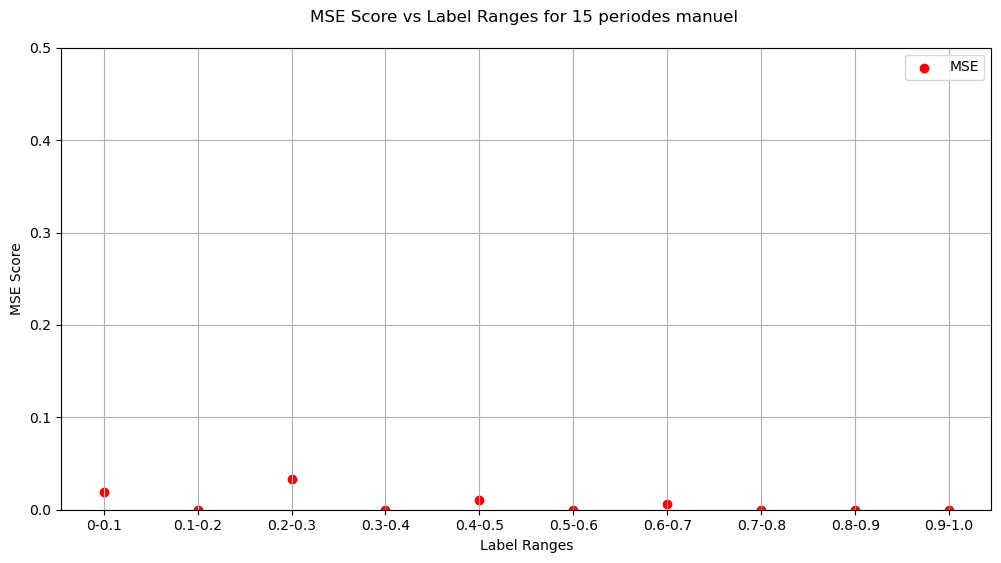

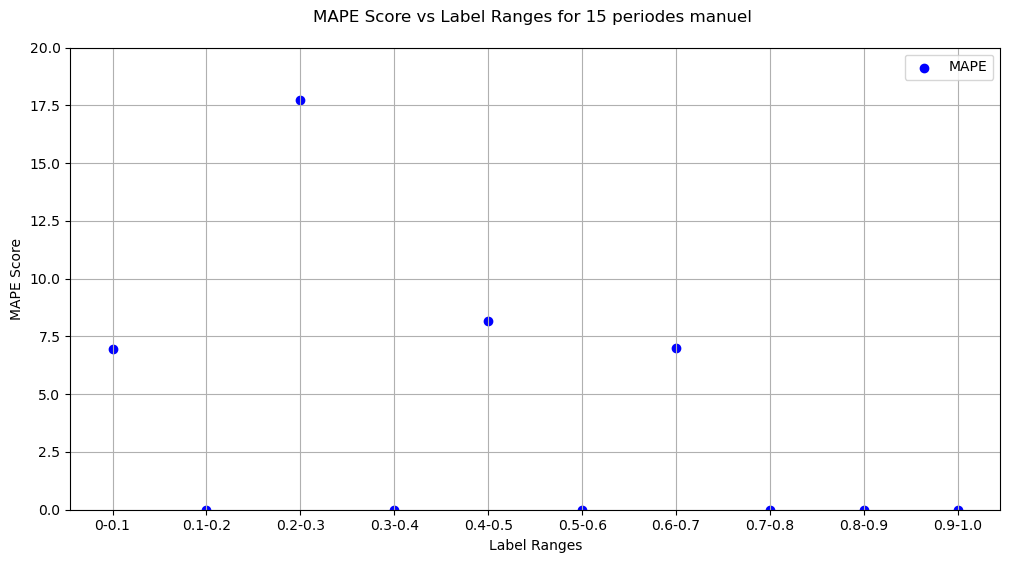

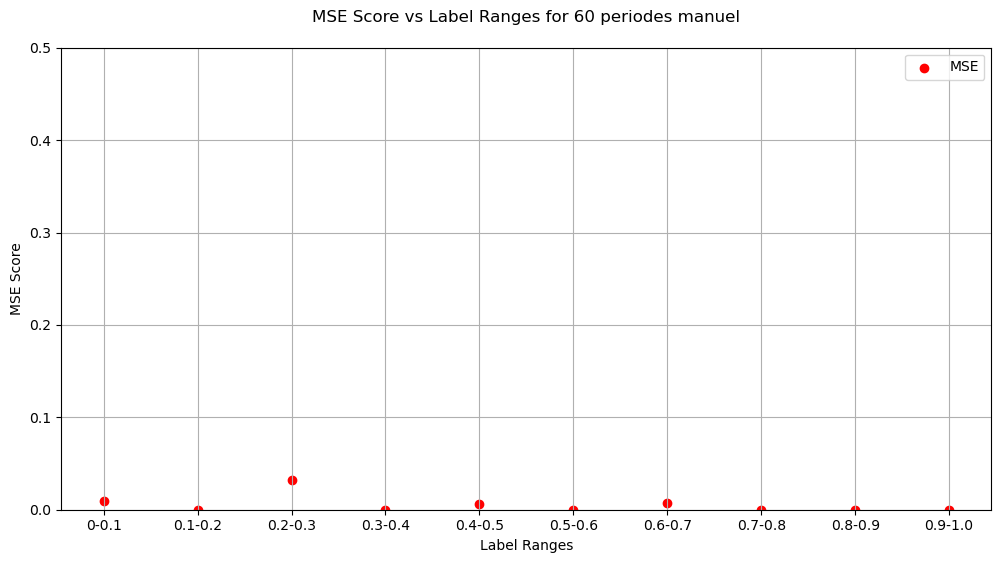

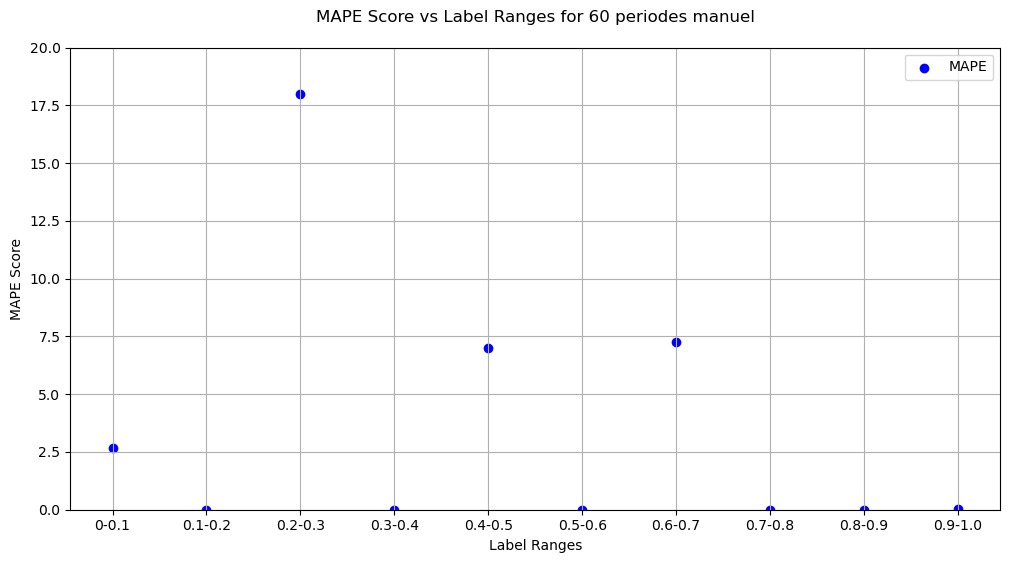

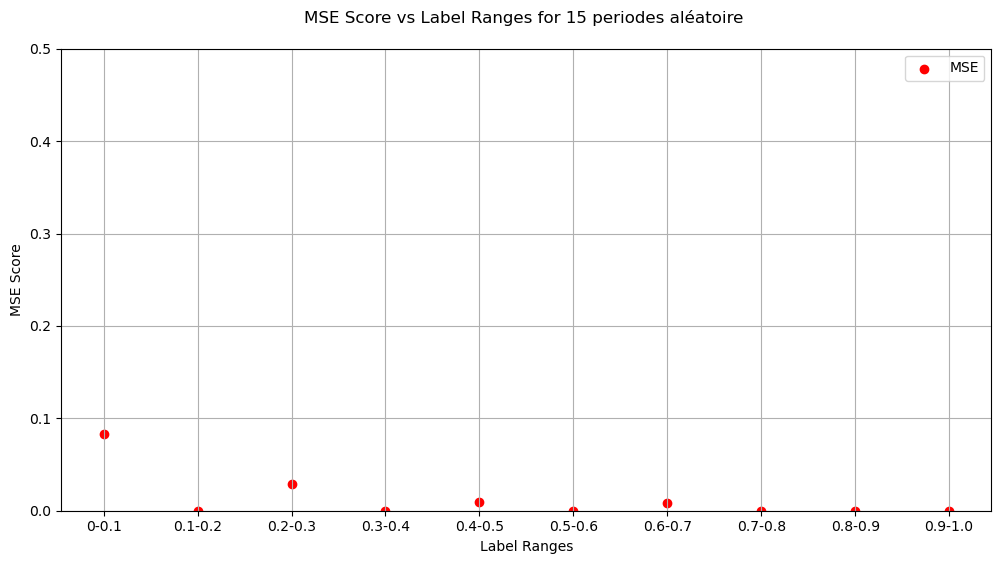

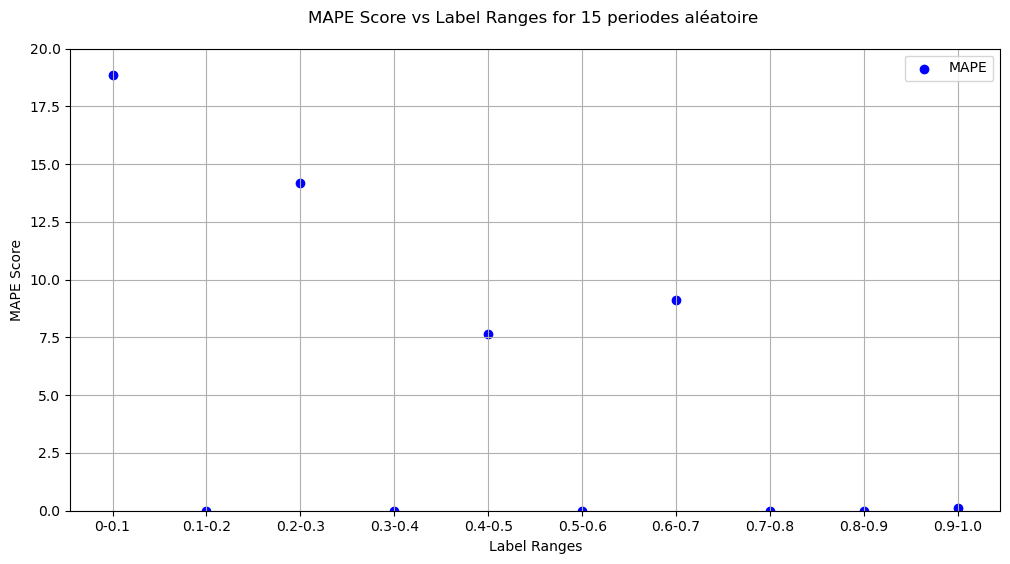

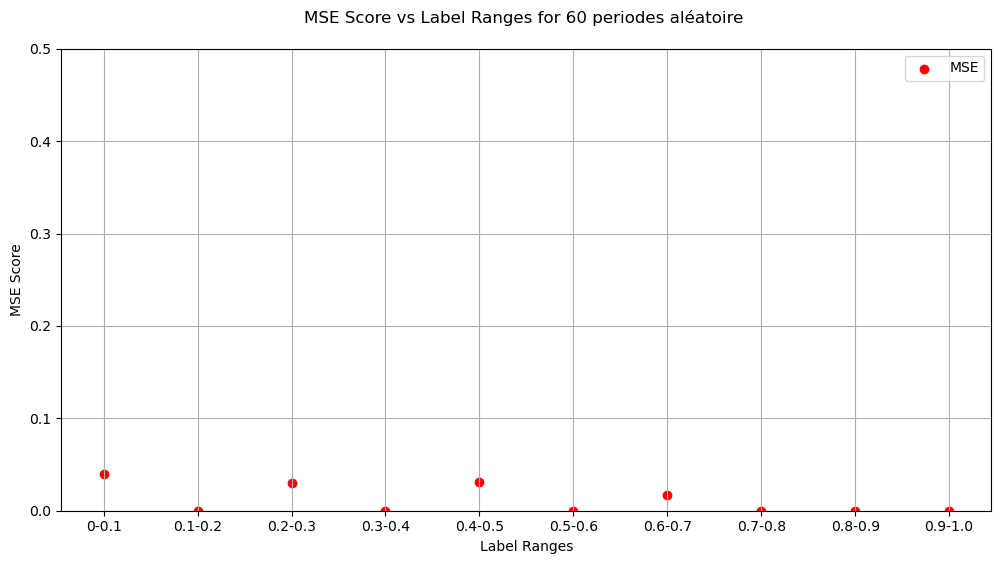

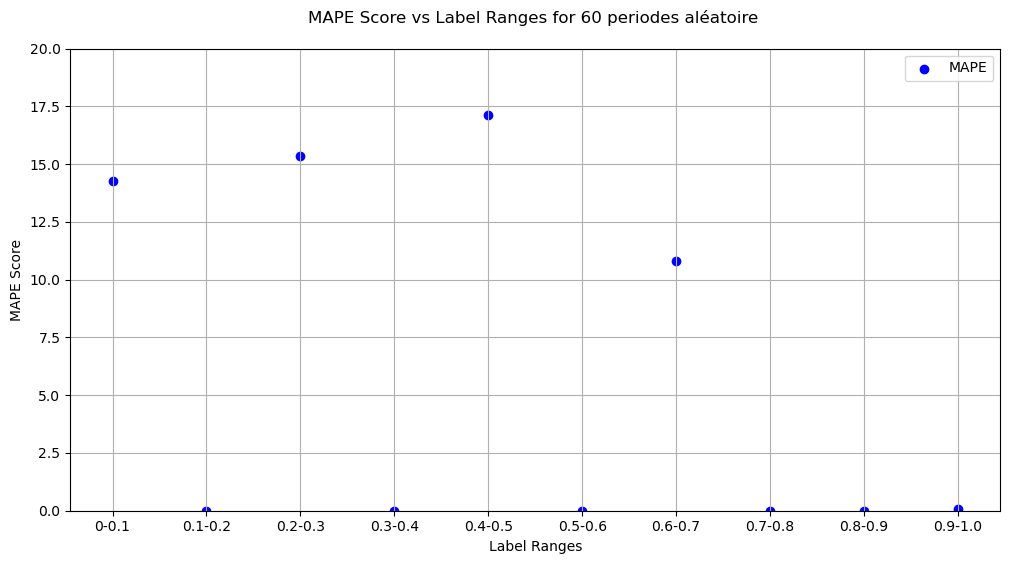

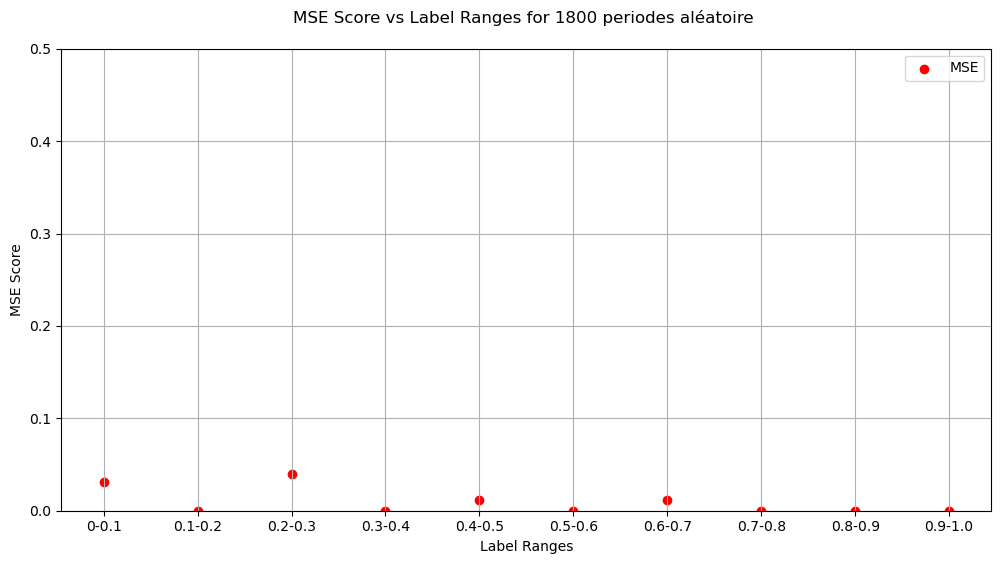

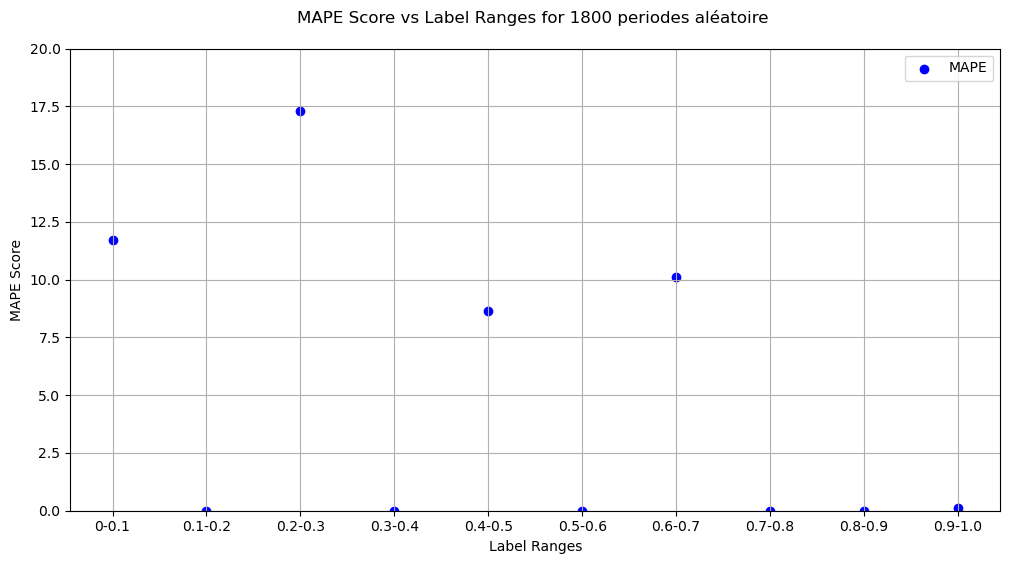

In [133]:
i = 1
for data in datas :
    view(data, i)
    i = i + 1